In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Get the last date of entry
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the date 365 days from the last date.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Retrieve the last 12 months of precipitation data
one_yr_prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()


![precipitation](Images/precipitation.png)

In [11]:
# Load the results into a pandas dataframe.

precipitation_df = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Reset the index to the 'Date'
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()

,Date,Prcp
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22


![describe](Images/describe.png)

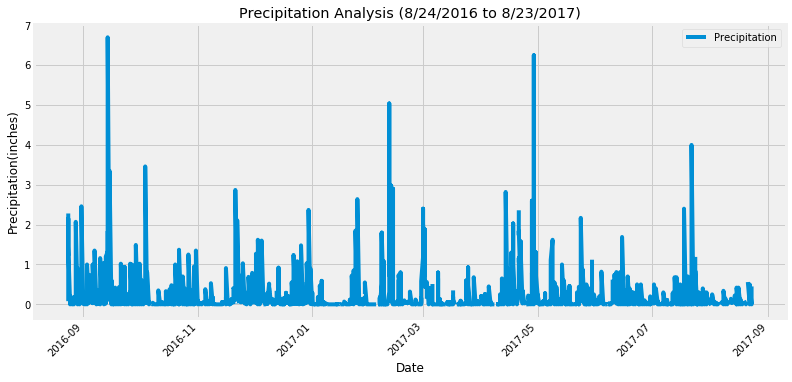

In [12]:
# Plot the dataframe as a horizontal bar chart using pandas plotting

precipitation_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)

plt.savefig("Images/precipitation.png")
plt.show()

In [13]:
precipitation_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Load the results into a pandas dataframe.

precipitation_sum = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

#Change the date to a datetime format.
precipitation_sum['Date'] = pd.to_datetime(precipitation_sum['Date'], format='%Y/%m/%d')

#precipitation_df.set_index('Date').head()
# Get the total for each station for each date and set the index as the date.
precipitation_totals = precipitation_sum.pivot_table(precipitation_sum, index=['Date'], aggfunc='mean')
precipitation_totals.head()

,Prcp
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [15]:
station_data = session.query(Station).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e87d8c2668>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

![precipitation](Images/station-histogram.png)

In [16]:
from sqlalchemy import func
num_stations = session.query(Station.station).group_by(Station.station).count()

In [17]:
num_stations

9

In [18]:
activity = session.query(Station.station, Station.name, Measurement.station, func.count(Measurement.tobs)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()


In [19]:
activity



[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [20]:
max_activity = activity[0][0:2]
max_activity

('USC00519281', 'WAIHEE 837.5, HI US')

In [21]:
temps_maxact = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == max_activity[0], Measurement.date > first_date).all()

In [22]:
len(temps_maxact)

351

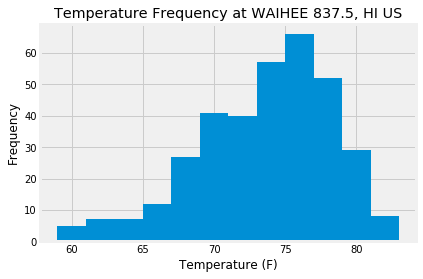

In [23]:
temps = [x[1] for x in temps_maxact]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))

plt.savefig("Images/Station.png")
plt.show()

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


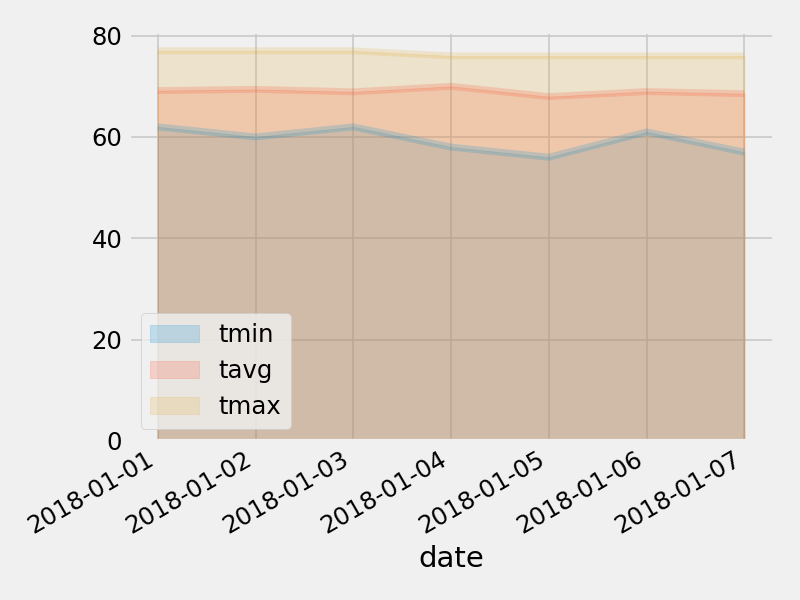

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
